In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf


# Configuration
SEQ_LENGTH = 60 
FEATURES = ['Close', 'MA_7', 'MA_30', 'Daily_Return', 'Volatility_7d']

# Pour la reproductibilité
np.random.seed(42)
tf.random.set_seed(42)

try:
    
    df = pd.read_csv('data/crypto_data_model_ready.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    print("Données chargées avec succès.")
except FileNotFoundError:
    print("Erreur : Le fichier 'data/crypto_data_model_ready.csv' est introuvable.")
   

data = df[FEATURES].values

# Normalisation 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
def create_sequences(data, seq_length):
    X, y = [], []
    target_col_index = 0 
    
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, target_col_index]) 
        
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, SEQ_LENGTH)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Fonction pour construire le modèle
def build_model(num_layers, neurons, input_shape):
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(LSTM(units=neurons, return_sequences=(num_layers > 1), input_shape=input_shape))
        else:
            model.add(LSTM(units=neurons, return_sequences=(i < num_layers - 1)))
        model.add(Dropout(0.2))
    model.add(Dense(units=max(1, neurons // 2)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Paramètres à tester
epochs_list = [50, 100]
neurons_list = [50, 100]
layers_list = [1, 2]

best_rmse = float('inf')
best_params = None

for epochs in epochs_list:
    for neurons in neurons_list:
        for num_layers in layers_list:
            print(f"Testing: layers={num_layers}, neurons={neurons}, epochs={epochs}")
            model = build_model(num_layers, neurons, (X_train.shape[1], X_train.shape[2]))
            early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=0)
            predictions = model.predict(X_test)
            dummy_array = np.zeros((len(predictions), len(FEATURES)))
            dummy_array[:, 0] = predictions.flatten()
            inverse_predictions = scaler.inverse_transform(dummy_array)[:, 0]
            dummy_y_test = np.zeros((len(y_test), len(FEATURES)))
            dummy_y_test[:, 0] = y_test
            inverse_y_test = scaler.inverse_transform(dummy_y_test)[:, 0]
            rmse = np.sqrt(np.mean((inverse_predictions - inverse_y_test)**2))
            print(f"RMSE: {rmse:.2f}")
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (epochs, neurons, num_layers)

print(f"\nBest params: epochs={best_params[0]}, neurons={best_params[1]}, layers={best_params[2]}, RMSE={best_rmse:.2f}")

# Entraîner le meilleur modèle
model = build_model(best_params[2], best_params[1], (X_train.shape[1], X_train.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=best_params[0],
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Données chargées avec succès.
X_train shape: (1388, 60, 5)
X_test shape: (347, 60, 5)
Testing: layers=1, neurons=50, epochs=50


c:\Users\sirin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
RMSE: 2446.02
Testing: layers=2, neurons=50, epochs=50


c:\Users\sirin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
RMSE: 2510.09
Testing: layers=1, neurons=100, epochs=50


c:\Users\sirin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
RMSE: 2460.70
Testing: layers=2, neurons=100, epochs=50


c:\Users\sirin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
RMSE: 2381.15
Testing: layers=1, neurons=50, epochs=100


c:\Users\sirin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
RMSE: 2296.52
Testing: layers=2, neurons=50, epochs=100


c:\Users\sirin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
RMSE: 2243.29
Testing: layers=1, neurons=100, epochs=100


c:\Users\sirin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
RMSE: 2421.93
Testing: layers=2, neurons=100, epochs=100


c:\Users\sirin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
RMSE: 2609.16

Best params: epochs=100, neurons=50, layers=2, RMSE=2243.29
Epoch 1/100


c:\Users\sirin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0144 - val_loss: 0.0063
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 8.8637e-04 - val_loss: 0.0017
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 8.4774e-04 - val_loss: 0.0011
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - l

In [6]:
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Prédictions train pour calculer R² train et nMAE train
train_pred = model.predict(X_train)
train_dummy = np.zeros((len(train_pred), len(FEATURES)))
train_dummy[:, 0] = train_pred.flatten()
train_inverse_pred = scaler.inverse_transform(train_dummy)[:, 0]

train_dummy_y = np.zeros((len(y_train), len(FEATURES)))
train_dummy_y[:, 0] = y_train
train_inverse_y = scaler.inverse_transform(train_dummy_y)[:, 0]

epsilon = 1e-8  

try:
    mae = mean_absolute_error(inverse_y_test, inverse_predictions)
    mape = np.mean(np.abs((inverse_y_test - inverse_predictions) / (np.abs(inverse_y_test) + epsilon))) * 100
    r2 = r2_score(inverse_y_test, inverse_predictions)

    mae_train = mean_absolute_error(train_inverse_y, train_inverse_pred)
    mape_train = np.mean(np.abs((train_inverse_y - train_inverse_pred) / (np.abs(train_inverse_y) + epsilon))) * 100
    r2_train = r2_score(train_inverse_y, train_inverse_pred)

    nmae_test = mae / (np.mean(np.abs(inverse_y_test)) + epsilon) * 100  
    nmae_train = mae_train / (np.mean(np.abs(train_inverse_y)) + epsilon) * 100

    print(f"RMSE (test) : {rmse:.2f} USD")
    print(f"MAE (test) : {mae:.2f} USD | nMAE (test) : {nmae_test:.2f}%")
    print(f"MAPE (test) : {mape:.2f}%")
    print(f"R² (test) : {r2:.4f}")
    print(f"MAE (train) : {mae_train:.2f} USD | nMAE (train) : {nmae_train:.2f}%")
    print(f"MAPE (train) : {mape_train:.2f}%")
    print(f"R² (train) : {r2_train:.4f}")

    

except ValueError as e:
    print(f"Erreur lors du calcul des métriques : {e}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
RMSE (test) : 2325.40 USD
MAE (test) : 1778.56 USD | nMAE (test) : 1.74%
MAPE (test) : 1.77%
R² (test) : 0.9596
MAE (train) : 1243.08 USD | nMAE (train) : 2.92%
MAPE (train) : 3.33%
R² (train) : 0.9927


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R² (entraînement) : 0.9927
R² (test) : 0.9596


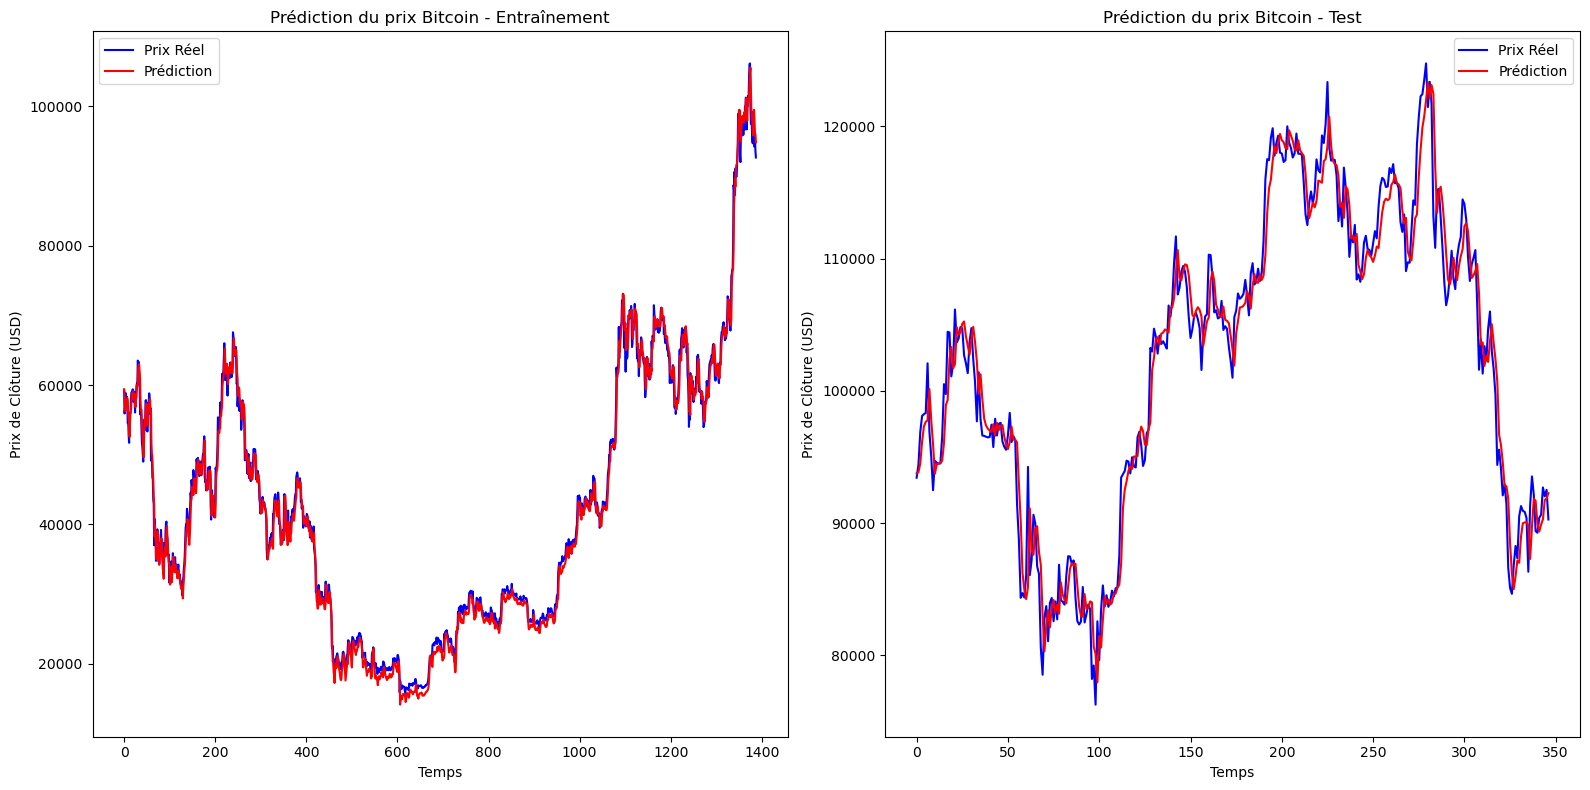

In [10]:
# Métriques supplémentaires pour le meilleur modèle (epochs=100, neurons=50, layers=2)
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Prédictions sur l'ensemble d'entraînement
train_predictions = model.predict(X_train)

# Inversion du scaling pour les prédictions d'entraînement
dummy_train_pred = np.zeros((len(train_predictions), len(FEATURES)))
dummy_train_pred[:, 0] = train_predictions.flatten()
train_predictions_inverse = scaler.inverse_transform(dummy_train_pred)[:, 0]

# Inversion du scaling pour les vraies valeurs d'entraînement
dummy_train_y = np.zeros((len(y_train), len(FEATURES)))
dummy_train_y[:, 0] = y_train
train_y_inverse = scaler.inverse_transform(dummy_train_y)[:, 0]

# Calcul de R² pour l'entraînement
r2_train = r2_score(train_y_inverse, train_predictions_inverse)

# R² pour le test (déjà calculé précédemment, mais on le rappelle)
r2_test = r2_score(inverse_y_test, inverse_predictions)

print(f"R² (entraînement) : {r2_train:.4f}")
print(f"R² (test) : {r2_test:.4f}")

# Courbes de prédiction pour l'entraînement
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title('Prédiction du prix Bitcoin - Entraînement')
plt.xlabel('Temps')
plt.ylabel('Prix de Clôture (USD)')
plt.plot(train_y_inverse, label='Prix Réel', color='blue')
plt.plot(train_predictions_inverse, label='Prédiction', color='red')
plt.legend()

# Courbes de prédiction pour le test (rappel)
plt.subplot(1, 2, 2)
plt.title('Prédiction du prix Bitcoin - Test')
plt.xlabel('Temps')
plt.ylabel('Prix de Clôture (USD)')
plt.plot(inverse_y_test, label='Prix Réel', color='blue')
plt.plot(inverse_predictions, label='Prédiction', color='red')
plt.legend()

plt.tight_layout()
plt.show()

Modèle XGBoost :
RMSE Train: 1189.85, R² Train: 0.9961
RMSE Test: 9381.20, R² Test: 0.3426
MAE Train: 818.10, MAPE Train: 1.93%
MAE Test: 7308.62, MAPE Test: 6.81%

Comparaison :
LSTM - RMSE Test: 2325.40, R² Test: 0.9596
XGBoost - RMSE Test: 9381.20, R² Test: 0.3426


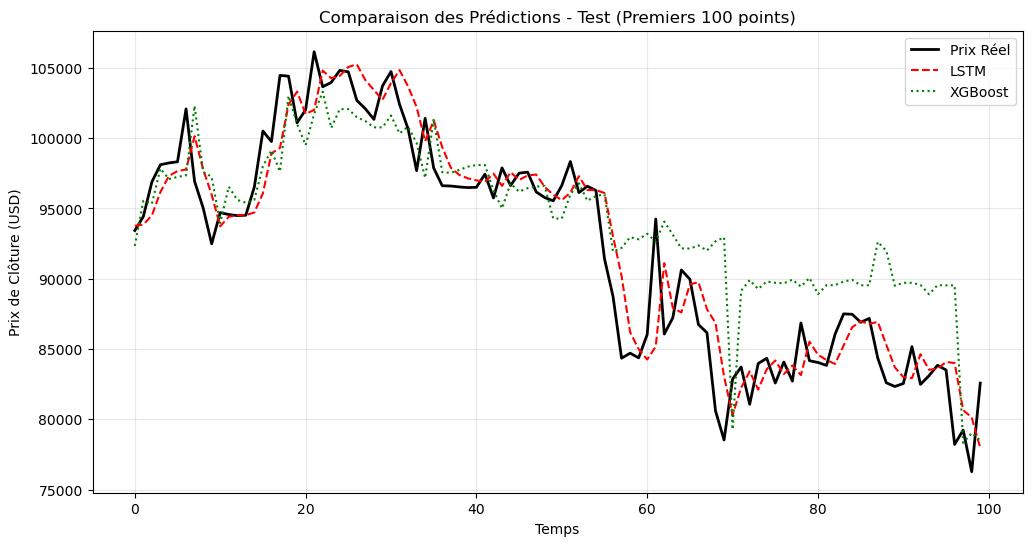

In [13]:
# Modèle simple pour comparaison : XGBoost sur les dernières valeurs des séquences
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Utiliser les dernières valeurs des séquences comme features (approximation simple)
X_train_simple = X_train[:, -1, :]  # Dernière timestep
X_test_simple = X_test[:, -1, :]

# Entraîner le modèle XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train_simple, y_train)

# Prédictions
pred_xgb_train = xgb_model.predict(X_train_simple)
pred_xgb_test = xgb_model.predict(X_test_simple)

# Inversion du scaling pour les prédictions
dummy_xgb_train = np.zeros((len(pred_xgb_train), len(FEATURES)))
dummy_xgb_train[:, 0] = pred_xgb_train
pred_xgb_train_inv = scaler.inverse_transform(dummy_xgb_train)[:, 0]

dummy_xgb_test = np.zeros((len(pred_xgb_test), len(FEATURES)))
dummy_xgb_test[:, 0] = pred_xgb_test
pred_xgb_test_inv = scaler.inverse_transform(dummy_xgb_test)[:, 0]

# Métriques pour le modèle XGBoost
rmse_xgb_test = np.sqrt(mean_squared_error(inverse_y_test, pred_xgb_test_inv))
r2_xgb_test = r2_score(inverse_y_test, pred_xgb_test_inv)

rmse_xgb_train = np.sqrt(mean_squared_error(train_y_inverse, pred_xgb_train_inv))
r2_xgb_train = r2_score(train_y_inverse, pred_xgb_train_inv)

# Ajouter MAE et MAPE
epsilon = 1e-8
mae_xgb_test = mean_absolute_error(inverse_y_test, pred_xgb_test_inv)
mape_xgb_test = np.mean(np.abs((inverse_y_test - pred_xgb_test_inv) / (np.abs(inverse_y_test) + epsilon))) * 100
mae_xgb_train = mean_absolute_error(train_inverse_y, pred_xgb_train_inv)
mape_xgb_train = np.mean(np.abs((train_inverse_y - pred_xgb_train_inv) / (np.abs(train_inverse_y) + epsilon))) * 100

print("Modèle XGBoost :")
print(f"RMSE Train: {rmse_xgb_train:.2f}, R² Train: {r2_xgb_train:.4f}")
print(f"RMSE Test: {rmse_xgb_test:.2f}, R² Test: {r2_xgb_test:.4f}")
print(f"MAE Train: {mae_xgb_train:.2f}, MAPE Train: {mape_xgb_train:.2f}%")
print(f"MAE Test: {mae_xgb_test:.2f}, MAPE Test: {mape_xgb_test:.2f}%")

# Comparaison avec le modèle LSTM
print("\nComparaison :")
print(f"LSTM - RMSE Test: {rmse:.2f}, R² Test: {r2_test:.4f}")
print(f"XGBoost - RMSE Test: {rmse_xgb_test:.2f}, R² Test: {r2_xgb_test:.4f}")

# Graphique de comparaison
plt.figure(figsize=(12, 6))
plt.plot(inverse_y_test[:100], label='Prix Réel', color='black', linewidth=2)  # Premiers 100 points pour lisibilité
plt.plot(inverse_predictions[:100], label='LSTM', color='red', linestyle='--')
plt.plot(pred_xgb_test_inv[:100], label='XGBoost', color='green', linestyle=':')
plt.title('Comparaison des Prédictions - Test (Premiers 100 points)')
plt.xlabel('Temps')
plt.ylabel('Prix de Clôture (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [14]:
# Sauvegarde des résultats pour l'app
import pickle
import json

# Résultats LSTM
lstm_results = {
    'model_name': 'LSTM',
    'best_params': best_params,
    'rmse_test': rmse,
    'mae_test': mae,
    'mape_test': mape,
    'r2_test': r2,
    'rmse_train': np.sqrt(np.mean((train_inverse_pred - train_inverse_y)**2)),
    'mae_train': mae_train,
    'mape_train': mape_train,
    'r2_train': r2_train,
    'y_test_true': inverse_y_test,
    'y_test_pred': inverse_predictions,
    'y_train_true': train_inverse_y,
    'y_train_pred': train_inverse_pred,
    'future_price': future_price,
    'last_known_price': df['Close'].iloc[-1]
}

# Résultats XGBoost
xgb_results = {
    'model_name': 'XGBoost',
    'rmse_test': rmse_xgb_test,
    'mae_test': mae_xgb_test,
    'mape_test': mape_xgb_test,
    'r2_test': r2_xgb_test,
    'rmse_train': rmse_xgb_train,
    'mae_train': mae_xgb_train,
    'mape_train': mape_xgb_train,
    'r2_train': r2_xgb_train,
    'y_test_true': inverse_y_test,
    'y_test_pred': pred_xgb_test_inv,
    'y_train_true': train_inverse_y,
    'y_train_pred': pred_xgb_train_inv
}

# Sauvegarder en pickle pour l'app
with open('data/model_results.pkl', 'wb') as f:
    pickle.dump({'lstm': lstm_results, 'xgb': xgb_results}, f)

# Sauvegarder en JSON pour compatibilité (sans arrays numpy)
results_json = {
    'lstm': {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in lstm_results.items()},
    'xgb': {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in xgb_results.items()}
}
with open('data/model_results.json', 'w') as f:
    json.dump(results_json, f, indent=4)

print("Résultats sauvegardés dans 'data/model_results.pkl' et 'data/model_results.json'")

Résultats sauvegardés dans 'data/model_results.pkl' et 'data/model_results.json'
